### 1. Dataset

In [1]:
%%time
import os
import logging
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin

logger = logging.getLogger(__name__)
setup_stream_logger(logger, level=logging.DEBUG)

os.makedirs("figures", exist_ok=True)

CPU times: user 1.58 s, sys: 1.81 s, total: 3.39 s
Wall time: 1.35 s


In [2]:
from marss2l import loaders
fs = get_remote_filesystem()

Using account key


In [3]:
from marss2l.plot import C0, C1, C2, C3, C4

We are using the test set to figure out the MDL:

In [4]:
from marss2l import loaders
# Import the dataset
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"
dataframe_data_traintest = loaders.read_csv(csv_path, 
                                            add_columns_for_analysis=True, 
                                            add_case_study=True,
                                            split="all",
                                            fs=None)
dataframe_data_traintest.shape

Using account key


(93581, 58)

In [5]:
# Have a look at the table columns, for reference
dataframe_data_traintest.columns

Index(['id_loc_image', 's2path', 'plumepath', 'cloudmaskpath', 'ch4path',
       'location_name_short', 'wind_u', 'wind_v', 'wind_speed', 'vza', 'sza',
       'percentage_clear', 'tile', 'isplume', 'ch4_fluxrate',
       'ch4_fluxrate_std', 'satellite', 'tile_date', 'notified', 'id_location',
       'last_update', 'location_name', 'country', 'lon', 'lat', 'offshore',
       'sector', 'monitoring', 'observability', 'background_image_tile',
       'footprint', 'plume', 'crs', 'transform_a', 'transform_b',
       'transform_c', 'transform_d', 'transform_e', 'transform_f', 'width',
       'height', 'window_row_off', 'window_col_off', 'window_height',
       'window_width', 'split_name', 'percent_overlap', 'year', 'year_month',
       'year_month_day', 'isplumeneg', 'date', 'satellite_constellation',
       'year_quarter', 'ch4_fluxrate_th', 'interval_ch4_fluxrate',
       'interval_ch4_fluxrate_str', 'case_study'],
      dtype='object')

Statistics are made with true positives

In [6]:
# Take positives only
df_data = dataframe_data_traintest[dataframe_data_traintest["ch4_fluxrate"] > 0]
# Filter also the test set
df_data = df_data[df_data['split_name']=='test_2023']
# Number of plumes by country
case_study_tables = df_data['case_study'].value_counts()
case_study_tables

case_study
Turkmenistan                  853
Algeria                       296
United States of America      144
Libya                         121
Arabian peninsula             103
Syrian Arab Republic           99
Iran (Islamic Republic of)     70
Uzbekistan & Kazakhstan        43
Offshore                       39
Egypt                          24
Rest                            8
Iraq                            7
Venezuela                       6
Name: count, dtype: int64

In [7]:
# Intersting countries
case_studies_sufficient_emissions = ['United States of America', 'Turkmenistan', 'Algeria', 'Libya', 'Arabian peninsula']
# Fultering by countrues
data = {case_study:df_data[df_data['case_study']==case_study] for case_study in case_studies_sufficient_emissions}
# #  Update with offshore
# data.update({'Offshore': df_data[df_data['offshore']==True]})
# countries.append('Offshore')
# Print the number of observations
[print(data[case_study].shape[0], case_study) for case_study in case_studies_sufficient_emissions]

144 United States of America
853 Turkmenistan
296 Algeria
121 Libya
103 Arabian peninsula


[None, None, None, None, None]

### 2. Empirical distributions

Measure the frequency of detections for 200 kg/h interval:

In [8]:
import numpy as np
# Define the bins
bins = range(0, 20000,400)
# Histogram of flowrates
q_hists = {case_study: np.histogram(data[case_study]['ch4_fluxrate'], bins = bins, density = True) for case_study in case_studies_sufficient_emissions}

Show the results for each satellite:

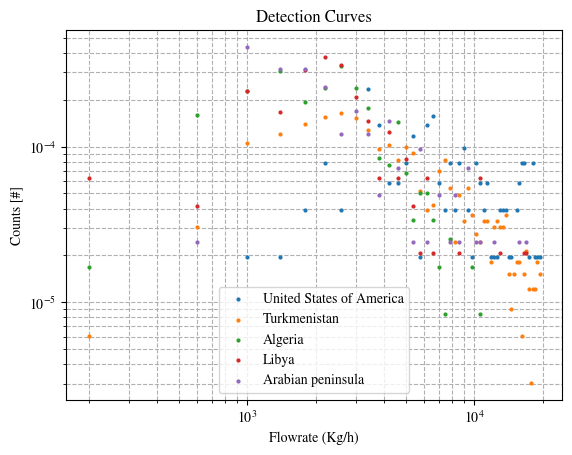

In [9]:
import numpy as np
import matplotlib.pylab as plt
# Centre of the labels
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Show the cumulative count
fig, ax = plt.subplots()
[ax.scatter(cntr, q_hists[case_study][0], s = 4, label = case_study) for case_study in case_studies_sufficient_emissions]
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Flowrate (Kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_axisbelow(True)
plt.title('Detection Curves'); plt.grid(True, which="both", ls="--"); plt.legend()

The model that describes the frequencies is the combination of two distribution funcitons: (1) a logistic function that represents the `Probability of Detection (PoD)` and (2) a power law equation representing the `Theoretical Plume Frequency Distribution (PFD)`. The response of every instrument is a combination of the two, which is the PoD multiplied by the PFD.

In [10]:
from scipy.stats import gamma

def pod(x, a, b):
    ''' Probability of detection as logistic function
    :param x: float. Flowrate.
    :param a: float. Steepness.
    :param b: float. Midpoint.
    '''
    # return gamma.pdf(x, a, b, c)
    return 1/(1 + 10**(-a*( x - b)))

def pfd(x, A, B):
    ''' Plume frequency distribution as power law
    :param x: float. Flowrate.
    :param A: float. Slope.
    :param B: float. Bias.
    '''
    return np.exp(A * np.log(x) + B)

def system_equations(x, a, b, A, B):
    # def system_equations(x, a, b, A, B):
    # return pod(x, a, b, c)
    return pod(x, a, b) * pfd(x, A, B)


Fit the equations to the histogram of every satellite:

In [11]:
from scipy.optimize import curve_fit
# Initial guess of the parameters - at the moment, very dependent on initial guess
initial_guess = [1, 1, -1, -1]
initial_guess = [0.001, 1000, -1, -1]
# Initialize the parameters
popts = {}; pcovs = {}
# For every satellite fit the curves
for case_study in case_studies_sufficient_emissions:
    # Flowrates as independent, Counts as depedent
    x = cntr; y = q_hists[case_study][0]
    # Avoid 0 values in counts
    x = x[y > 0]; y = y[y > 0]
    # Compute the parameters
    popt, pcov = curve_fit(system_equations, x, y, p0=initial_guess)
    # Save the results
    popts.update({case_study: popt})
    pcovs.update({case_study: pcov})

Prepare a Monte Carlo simulation considering all the uncertainties involved:

In [12]:
# Number of Monte Carlo runs
n = 1000
# Bins to count the frequency of flowrates
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Flowrates to compute the PoD
flw = np.linspace(0, 10000, 10000)
# Save modellign results for reach satellite
model_means = {}; model_sds = {}
pod_means = {}; pod_sds = {}
# For every satellite fit the curves
for case_study in case_studies_sufficient_emissions:
    # Results of the simulations of frequencies
    freq = np.ones((n, len(cntr)))
    # Results of the simulations of PoDs
    pods = np.ones((n, len(flw)))
    # Sample the parameter distribution
    params = np.random.multivariate_normal(popts[case_study], pcovs[case_study], size = n)
    # Rund the model multiple times
    for i in range(n):
        # Compute the frequencies with these parameters
        freq[i,:] = system_equations(cntr, params[i, 0], params[i, 1], params[i, 2], params[i,3])
        pods[i,:] = pod(flw,  params[i, 0], params[i, 1])
        # Compute the pods
    # Compute statistics
    freq_model_mu = np.mean(freq, axis = 0); model_means.update({case_study: freq_model_mu})
    freq_model_sd = np.std(freq, axis = 0); model_sds.update({case_study: freq_model_sd})
    pod_model_mu = np.mean(pods, axis = 0); pod_means.update({case_study: pod_model_mu})
    pod_model_sd = np.std(pods, axis = 0); pod_sds.update({case_study: pod_model_sd})

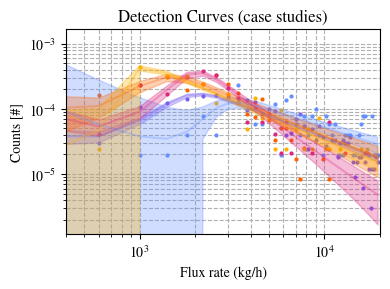

In [13]:
import matplotlib.pylab as plt
# Set the colors and markers
colors = {'United States of America':C0, 
          'Turkmenistan':C1, 
          'Algeria':C3, 'Libya':C2, 
          'Arabian peninsula': C4}
markers = {'United States of America':'o', 'Turkmenistan':'x', 'Algeria':'+', 'Libya':'-', 'Arabian peninsula': '^'}
# Initialize the plots
fig, ax = plt.subplots(1,1, figsize=(4, 3), tight_layout=True)
# Show the frequency dots
[ax.scatter(cntr, q_hists[case_study][0], s = 4, label = case_study, color = colors[case_study]) for case_study in case_studies_sufficient_emissions]
# Show the mean value of the curve
[ax.plot(cntr, model_means[case_study], alpha = 0.3, color = colors[case_study]) for case_study in case_studies_sufficient_emissions]
# And the standard deviations
[ax.fill_between(cntr, 
                 model_means[case_study]-model_sds[case_study], 
                 model_means[case_study]+model_sds[case_study], 
                 color = colors[case_study], alpha = 0.3) for case_study in case_studies_sufficient_emissions]
# Formatring
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Flux rate (kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_xlim(400,20000)
ax.set_axisbelow(True)
plt.title('Detection Curves (case studies)'); plt.grid(True, which="both", ls="--"); 
# ax.legend(loc="upper right")
plt.savefig("figures/detection_curves_by_region.pdf")

In [14]:
# Create empty dictionary to store Minimum Detectable Limits (MDLs) for each case study
mdls = {}

# Loop through each case study that has sufficient emissions data
for case_study in case_studies_sufficient_emissions:
    # List to store the MDL results for this case study
    case_study_mdls = []
    
    # Get the probability of detection (POD) data for this case study
    mean_pod = pod_means[case_study]
    sd_pod = pod_sds[case_study]
    
    # ----- MDLs at 50% detection probability -----
    
    # Find where mean+sd crosses 50% threshold (minimum MDL - optimistic estimate)
    optimistic_index = np.where((mean_pod + sd_pod) > 0.5)[0][0]
    optimistic_mdl = int(round(flw[optimistic_index]))
    case_study_mdls.append({'Q50_min': optimistic_mdl})
    
    # Find where mean crosses 50% threshold (mean MDL - best estimate)
    mean_index = np.where(mean_pod > 0.5)[0][0]
    mean_mdl = int(round(flw[mean_index]))
    case_study_mdls.append({'Q50_mean': mean_mdl})
    
    # Find where mean-sd crosses 50% threshold (maximum MDL - conservative estimate)
    conservative_index = np.where((mean_pod - sd_pod) > 0.5)[0][0]
    conservative_mdl = int(round(flw[conservative_index]))
    case_study_mdls.append({'Q50_max': conservative_mdl})
    
    # ----- MDLs at 90% detection probability -----
    
    # Find where mean+sd crosses 90% threshold (minimum MDL - optimistic estimate)
    optimistic_index_90 = np.where((mean_pod + sd_pod) > 0.9)[0][0]
    optimistic_mdl_90 = int(round(flw[optimistic_index_90]))
    case_study_mdls.append({'Q90_min': optimistic_mdl_90})
    
    # Find where mean crosses 90% threshold (mean MDL - best estimate)
    mean_index_90 = np.where(mean_pod > 0.9)[0][0]
    mean_mdl_90 = int(round(flw[mean_index_90]))
    case_study_mdls.append({'Q90_mean': mean_mdl_90})
    
    # Find where mean-sd crosses 90% threshold (maximum MDL - conservative estimate)
    # conservative_index_90 = np.where((mean_pod - sd_pod) > 0.9)[0][0]
    # conservative_mdl_90 = int(round(flw[conservative_index_90]))
    # case_study_mdls.append({'Q90_max': conservative_mdl_90})
    
    # Store all MDL results for this case study
    mdls[case_study] = case_study_mdls

mdls

{'United States of America': [{'Q50_min': 2204},
  {'Q50_mean': 2496},
  {'Q50_max': 2848},
  {'Q90_min': 2935},
  {'Q90_mean': 3748}],
 'Turkmenistan': [{'Q50_min': 1497},
  {'Q50_mean': 1575},
  {'Q50_max': 1660},
  {'Q90_min': 2159},
  {'Q90_mean': 2298}],
 'Algeria': [{'Q50_min': 990},
  {'Q50_mean': 1129},
  {'Q50_max': 1280},
  {'Q90_min': 1454},
  {'Q90_mean': 1699}],
 'Libya': [{'Q50_min': 1671},
  {'Q50_mean': 1768},
  {'Q50_max': 1866},
  {'Q90_min': 2191},
  {'Q90_mean': 2320}],
 'Arabian peninsula': [{'Q50_min': 834},
  {'Q50_mean': 887},
  {'Q50_max': 937},
  {'Q90_min': 1005},
  {'Q90_mean': 1080}]}

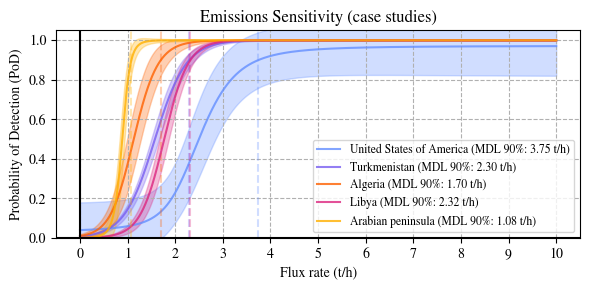

In [15]:
# Show the probabilities of detection for each satellite
fig, ax = plt.subplots(figsize=(6,3), tight_layout=True)

# Plot every curve with Q90 value in the legend
for case_study in case_studies_sufficient_emissions:
    # Get the mean probability of detection for this case study
    mean_pod = pod_means[case_study]
    # Get the color associated with this case study
    case_color = colors[case_study]
    
    # Get the Q90 detection threshold value
    q90_value = mdls[case_study][4]['Q90_mean']
    
    # Create legend label that includes the Q90 value
    legend_label = f"{case_study} (MDL 90%: {q90_value/1_000:.2f} t/h)"
    
    # Plot the mean probability of detection curve with updated label
    ax.plot(flw, mean_pod, alpha=0.8, label=legend_label, color=case_color)
    
    # Add confidence bands (mean ± standard deviation)
    lower_bound = mean_pod - pod_sds[case_study]
    upper_bound = mean_pod + pod_sds[case_study]
    ax.fill_between(flw, lower_bound, upper_bound, alpha=0.3, color=case_color)
    
    # Draw vertical line at the Q90 threshold (but no text label)
    ax.axvline(q90_value, color=case_color, alpha=0.3, linestyle='--')

# Add reference lines at x=0 and y=0
ax.axhline(0, color='black')
ax.axvline(0, color='black')

# Insert labels to x and y axes
ax.set_title('Emissions Sensitivity (case studies)')
ax.set_xlabel('Flux rate (t/h)')
ax.set_ylabel('Probability of Detection (PoD)')
ax.set_xticks(range(0,11_000,1_000), [f"{d/1000:.0f}" for d in range(0,11_000,1_000)])

# Show the legend and grid
ax.grid(linestyle='--')
ax.set_ylim(0,1.05)
ax.legend(loc='best', fontsize='small')
plt.savefig("figures/mdl_by_region.pdf")